# CP Online Verification Example 5

In this notebook, we showcase examples of CP verification (example 5) to accompany the survey paper: "Formal Verification and Control with Conformal Prediction

In [1]:
# Let's first import all necessary modules.
import math
import numpy as np
from numpy import random
from numpy import deg2rad
from numpy import shape
from numpy import array
import matplotlib.pyplot as plt
from aerobench.run_f16_sim import run_f16_sim
from aerobench.visualize import plot
from aerobench.examples.gcas.gcas_autopilot import GcasAutopilot
import matplotlib as mpl
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch
import json

# Example 5: Predictive Online Verification with Conformal Prediction.

Let's consider the setup from [1]. You can find the codes in https://github.com/stanleybak/AeroBenchVVPython.git, which we use in this example. The benchmark is also considered in [2] and [3]. We remark that we use repeated codes from [3].

To start with, let's construct a simulatable plane system. For our verification purpose, let's assume that the system comes from a distribution with the initial altitude of N(1000, 10^2) and initial velocity of N(650, 5^2), with all other hyperparameters remain the same. We observe the states of altitudes and velocities (air speeds).

In [2]:
# Set a seed.
selected_seed = 100
random.seed(selected_seed)

# Codes for parameters of plotting.
mpl.rcParams.update(mpl.rcParamsDefault)
font = {'size' : 17}
mpl.rc('font', **font)


# Define hyperparameters for the simulation.
power = 9  # engine power level (0-10)
alpha = deg2rad(2.1215)  # Trim Angle of Attack (rad)
beta = 0  # Side slip angle (rad)
phi = -math.pi / 8  # Roll angle from wings level (rad)
theta = (-math.pi / 2) * 0.3  # Pitch angle from nose level (rad)
psi = 0  # Yaw angle from North (rad)
tmax = 5  # simulation time
simulation_step = 1 / 30

# distributional information.
nominal_alt_mean = 1000
nominal_alt_std = 10
nominal_vel_mean = 650
nominal_vel_std = 5


# Write a class for simulation purpose.
class Plane:
    def __init__(self, power, alpha, beta, phi, theta, psi, tmax, step, nominal_alt_mean, nominal_alt_std, nominal_vel_mean, nominal_vel_std):
        # This function initializes the system.
        self.power = power # engine power level (0 - 10)
        self.alpha = alpha # Trim Angle of Attack (rad)
        self.beta = beta # Side slip angle (rad)
        self.phi = phi # Roll angle from wings level (rad)
        self.theta = theta # Pitch angle from nose level (rad)
        self.psi = psi # Yaw angle from North (rad)
        self.tmax = tmax
        self.step = step
        
        # Distributional info.
        self.nominal_alt_mean = nominal_alt_mean
        self.nominal_alt_std = nominal_alt_std
        self.nominal_vel_mean = nominal_vel_mean
        self.nominal_vel_std = nominal_vel_std
        
    def generate_nominal_trajectory(self, tmax, step):
        # First, randomly select an initial altitude based on the distribution info.
        alt = random.normal(self.nominal_alt_mean, self.nominal_alt_std)
        vel = random.normal(self.nominal_vel_mean, self.nominal_vel_std)
        init_state = [vel, self.alpha, self.beta, self.phi, self.theta, self.psi, 0, 0, 0, 0, 0, alt, self.power]
        ap = GcasAutopilot(init_mode='roll', stdout=True, gain_str='old')
        res = run_f16_sim(init_state, tmax, ap, step=step, extended_states=True)
        altitude =  list(plot.return_single(res, 'alt')[1])
        velocity = list(plot.return_single(res, 'vt')[1])
        return altitude, velocity

Let's plot 3 sample trajectories generated from the distribution for illustration purpose. Note that each trajectory contains 151 timestamps in total ranging from time 0 to time 150 (We scaled the time unit for simplicity).

Shape of illustion for altitudes: (3, 151)
Shape of illustion for velocities: (3, 151)


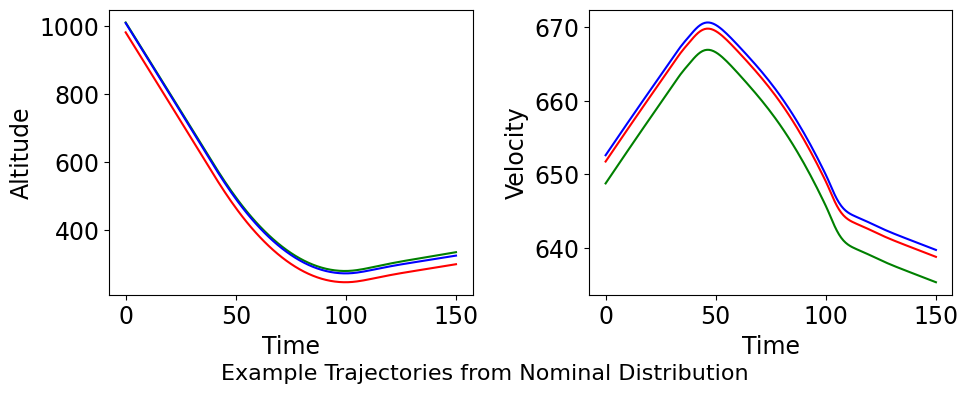

In [3]:
plane = Plane(power, alpha, beta, phi, theta, psi, tmax, simulation_step, nominal_alt_mean, nominal_alt_std, nominal_vel_mean, nominal_vel_std)
illustration_altitudes = []
illustration_velocities = []
for _ in range(3):
    altitude, velocity = plane.generate_nominal_trajectory(tmax, simulation_step)
    illustration_altitudes.append(altitude)
    illustration_velocities.append(velocity)


# Write a function for illustration purpose.
def plot_trajectories(altitudes, velocities, title = "", save_title = ""):    
    colors = ["r", "g", "b"]
    time_stamps = [i for i in range(len(altitudes[0]))]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    for i in range(len(altitudes)):
        ax1.plot(time_stamps, altitudes[i], color = colors[i])
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Altitude")
    
    for i in range(len(velocities)):
        ax2.plot(time_stamps, velocities[i], color = colors[i])
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Velocity")
    
    plt.tight_layout()
    fig.suptitle(title, y=0.05, fontsize=16)
    if save_title != "":
        plt.savefig("plots/" + save_title + ".pdf")
    plt.show()

    
# Write a function for illustrating predictions as well, which will come handy later.
def plot_trajectories_with_predictions(altitudes, velocities, pred_altitudes, pred_velocities, current_time, title = "", save_title = ""):
    colors = ["r", "g", "b"]
    time_stamps = [i for i in range(len(altitudes[0]))]
    pred_time_stamps = [i for i in range(current_time + 1, len(altitudes[0]))]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    for i in range(len(altitudes)):
        ax1.plot(time_stamps, altitudes[i], color = colors[i])
        ax1.plot(pred_time_stamps, pred_altitudes[i][current_time + 1:], color = colors[i], linestyle = "dashed")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Altitude")
    
    for i in range(len(velocities)):
        ax2.plot(time_stamps, velocities[i], color = colors[i])
        ax2.plot(pred_time_stamps, pred_velocities[i][current_time + 1:], color = colors[i], linestyle = "dashed")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Velocity")
    
    plt.tight_layout()
    fig.suptitle(title, y=0.05, fontsize=16)
    if save_title != "":
        plt.savefig("plots/" + save_title + ".pdf")
    plt.show()

    
terminal_time = len(illustration_altitudes[0]) - 1
print("Shape of illustion for altitudes:", shape(illustration_altitudes))
print("Shape of illustion for velocities:", shape(illustration_velocities))
plot_trajectories(illustration_altitudes, illustration_velocities, title = "Example Trajectories from Nominal Distribution")

Now, let's train an LSTM predictor and set the current time t = 80 with a training size of 100.

In [4]:
current_time = 80
training_size = 100
validation_size = 50
n_epochs_alt = 1000
n_epochs_vel = 5000


class Predictor(nn.Module):
    # Write a class for the predictor.
    def __init__(self, set_inputsize, set_outputsize):
        super().__init__()
        self.lstm = nn.LSTM(input_size=set_inputsize, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, set_outputsize)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

def train_predictor(train_x, train_y, validation_x, validation_y, n_epochs):
    predictor = Predictor(len(train_x[0]), len(train_y[0]))
    optimizer = optim.Adam(predictor.parameters())
    loss_fn = nn.MSELoss()
    loader = data.DataLoader(data.TensorDataset(train_x, train_y), shuffle=True, batch_size=8)
    for epoch in range(n_epochs):
        predictor.train()
        for X_batch, y_batch in loader:
            y_pred = predictor(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Validation
        if epoch % 100 != 0:
            continue
        predictor.eval()
        with torch.no_grad():
            y_pred = predictor(train_x)
            train_rmse = np.sqrt(loss_fn(y_pred, train_y))
            y_pred = predictor(validation_x)
            validation_rmse = np.sqrt(loss_fn(y_pred, validation_y))
        print("Epoch %d: train RMSE %.4f, validation RMSE %.4f" % (epoch, train_rmse, validation_rmse))
    return predictor


def generate_predictions(altitude_prefixes, velocity_prefixes, alt_predictor, vel_predictor, normalization_constant):
    # First, normalize the prefixes.
    altitude_prefixes_normalized = array(altitude_prefixes) / normalization_constant
    velocity_prefixes_normalized = array(velocity_prefixes) / normalization_constant
    # Generate predictions.
    with torch.no_grad():
        alt_y_pred = array(alt_predictor(torch.FloatTensor(np.array(altitude_prefixes_normalized)))) * normalization
    with torch.no_grad():
        vel_y_pred = array(vel_predictor(torch.FloatTensor(np.array(velocity_prefixes_normalized)))) * normalization
    # Piece together the predicted trajectories and the predictions.
    for i in range(len(altitude_prefixes)):
        altitude_prefixes[i].extend(list(alt_y_pred[i]))
        velocity_prefixes[i].extend(list(vel_y_pred[i]))
    return altitude_prefixes, velocity_prefixes

normalization = 1000 # For training purpose, let's use a normalization constant.

# We have trained a predictor and saved it for you. If you want to retrain a predictor, uncomment the lines below.

# # Generate a training set.
# training_trajs = [plane.generate_nominal_trajectory(tmax, simulation_step) for i in range(training_size)]
# training_alts = [training_trajs[i][0] for i in range(training_size)]
# training_vels = [training_trajs[i][1] for i in range(training_size)]
# training_x_alts = torch.FloatTensor(array([training_alts[i][:current_time + 1] for i in range(training_size)]) / normalization)
# training_y_alts = torch.FloatTensor(array([training_alts[i][current_time + 1:] for i in range(training_size)]) / normalization)
# training_x_vels = torch.FloatTensor(array([training_vels[i][:current_time + 1] for i in range(training_size)]) / normalization)
# training_y_vels = torch.FloatTensor(array([training_vels[i][current_time + 1:] for i in range(training_size)]) / normalization)

# # Generate validation set.
# validation_trajs = [plane.generate_nominal_trajectory(tmax, simulation_step) for i in range(validation_size)]
# validation_alts = [validation_trajs[i][0] for i in range(validation_size)]
# validation_vels = [validation_trajs[i][1] for i in range(validation_size)]
# validation_x_alts = torch.FloatTensor(array([validation_alts[i][:current_time + 1] for i in range(validation_size)]) / normalization)
# validation_y_alts = torch.FloatTensor(array([validation_alts[i][current_time + 1:] for i in range(validation_size)]) / normalization)
# validation_x_vels = torch.FloatTensor(array([validation_vels[i][:current_time + 1] for i in range(validation_size)]) / normalization)
# validation_y_vels = torch.FloatTensor(array([validation_vels[i][current_time + 1:] for i in range(validation_size)]) / normalization)

# # Train an LSTM predictor for Altitudes.
# print("Training LSTM Predictor for Altitudes")
# alt_predictor = train_predictor(training_x_alts, training_y_alts, validation_x_alts, validation_y_alts, n_epochs_alt)
# torch.save(alt_predictor.state_dict(), 'predictors/alt_predictor.pth')
# print()

# print("Training LSTM Predictor for Velocities")
# vel_predictor = train_predictor(training_x_vels, training_y_vels, validation_x_vels, validation_y_vels, n_epochs_vel)
# torch.save(vel_predictor.state_dict(), 'predictors/vel_predictor.pth')
# print()

# Load the predictors.
alt_predictor= Predictor(current_time + 1, terminal_time - current_time)
alt_predictor.load_state_dict(torch.load('predictors/alt_predictor.pth'))
alt_predictor.eval()

vel_predictor= Predictor(current_time + 1, terminal_time - current_time)
vel_predictor.load_state_dict(torch.load('predictors/vel_predictor.pth'))
vel_predictor.eval()

Predictor(
  (lstm): LSTM(81, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=70, bias=True)
)

Let's illustrate some predictions with the solid lines as ground truths and the dashed lines as predictions.

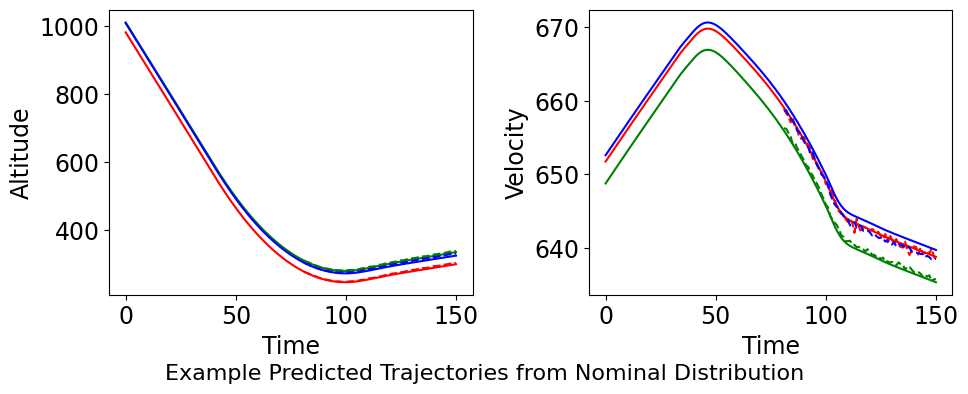

In [5]:
# Illustrate the predictions
illustration_altitude_prefixes = [illustration_altitudes[i][:current_time + 1] for i in range(len(illustration_altitudes))]
illustration_velocity_prefixes = [illustration_velocities[i][:current_time + 1] for i in range(len(illustration_velocities))]
pred_illu_altitudes, pred_illu_velocities = generate_predictions(illustration_altitude_prefixes, illustration_velocity_prefixes, alt_predictor, vel_predictor, normalization)
plot_trajectories_with_predictions(illustration_altitudes, illustration_velocities, pred_illu_altitudes, pred_illu_velocities, current_time, title = "Example Predicted Trajectories from Nominal Distribution", save_title = "example_predictions_nominal")

# Save the trajectories.
with open("results/illustration_altitudes.json", "w") as file:
    saved_illustration_altitudes = []
    for altitude in illustration_altitudes:
        saved_illustration_altitudes.append([float(value) for value in altitude])
    json.dump(saved_illustration_altitudes, file)
with open("results/illustration_velocities.json", "w") as file:
    saved_illustration_velocities = []
    for velocity in illustration_velocities:
        saved_illustration_velocities.append([float(value) for value in velocity])
    json.dump(saved_illustration_velocities, file)
with open("results/pred_illu_altitudes.json", "w") as file:
    saved_pred_illu_altitudes = []
    for altitude in pred_illu_altitudes:
        saved_pred_illu_altitudes.append([float(value) for value in altitude])
    json.dump(saved_pred_illu_altitudes, file)
with open("results/pred_illu_velocities.json", "w") as file:
    saved_pred_illu_velocities = []
    for velocity in pred_illu_velocities:
        saved_pred_illu_velocities.append([float(value) for value in velocity])
    json.dump(saved_pred_illu_velocities, file)
with open("results/current_time.json", "w") as file:
    json.dump(current_time, file)

Recall that for the indirect method, we can use either 1. the union bound or 2. normalization. We will use normalization constant in this tutorial since it is supposed to be tighter. To use the normalization trick, we need to compute the normalization constants. Let's use the trick where we simply normalize the prediction error on an additional dataset (in fact, the training dataset should also suffice).

In [6]:
# Generate an additional dataset.
alpha_computation_size = 100
alpha_alts = []
alpha_vels = []
for _ in range(alpha_computation_size):
    altitude, velocity = plane.generate_nominal_trajectory(tmax, simulation_step)
    alpha_alts.append(altitude)
    alpha_vels.append(velocity)
# Next, we generate predictions.
alpha_alts_prefixes = [alpha_alts[j][:current_time + 1] for j in range(len(alpha_alts))]
alpha_vels_prefixes = [alpha_vels[j][:current_time + 1] for j in range(len(alpha_vels))]
alpha_pred_alts, alpha_pred_vels = generate_predictions(alpha_alts_prefixes, alpha_vels_prefixes, alt_predictor, vel_predictor, normalization)
# Now, compute the alphas.
alphas = dict()
for tau in range(current_time + 1, terminal_time + 1):
    error_list = []
    for i in range(alpha_computation_size):
        ground_alt = alpha_alts[i][tau]
        pred_alt = alpha_pred_alts[i][tau]
        ground_vel = alpha_vels[i][tau]
        pred_vel = alpha_pred_vels[i][tau]
        error = ((ground_alt - pred_alt) ** 2 + (ground_vel - pred_vel) ** 2) ** (1 / 2)
        error_list.append(error)
    alphas[tau] = 1 / max(error_list)

Let's now perform verification, where we care about the following specification:

Globally_[0, T](p >= zeta_1 and (p <= zeta_2 implies v <= zeta_3)), where zeta_1 = 100, zeta_2 = 300, zeta_3 = 650.

The specification is to ensure safety where we monitor if there is no low-altitude flying and if the plane is below an altitude threshold, the speed should be slow enough to ensure safety. Note that the specification is equivalent to:

Globally_[0, T](p >= zeta_1 and (p >= zeta_2 or v <= zeta_3)).

The specification comes with three predicate functions. p - zeta_1, p - zeta_2, and zeta_3 - v and is now in positive normal form.

Let's conduct experiments: We conduct 50 experiments, for each experiment, we use 700 calibration trajectories to calculate the prediction region C. We then caculate the coverage over 200 ground truth test trajectories of rho^phi(X, 0) >= rho^* for validation (for each of the methods). For illustration, we also plot the histogram of nonconformity scores and the scatter plots of the ground truth robust semantics vs. the rho^* for the test data in the first experimental trial. Let's consider an expected failure probability of 0.1.

Conducting Experiment  1
Performing Experiment with the Direct Method.


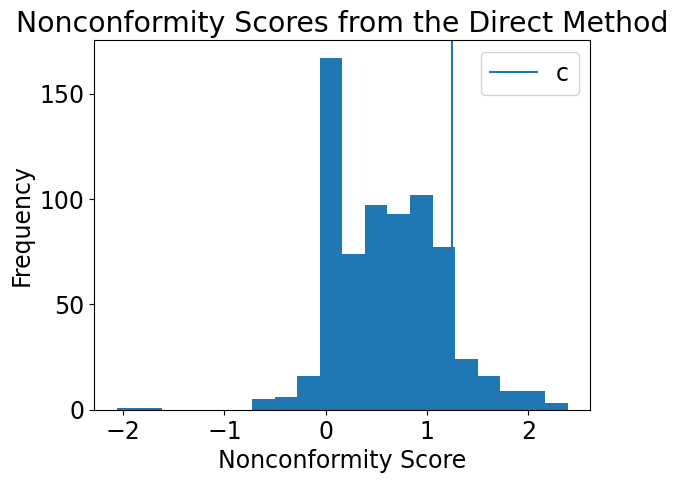

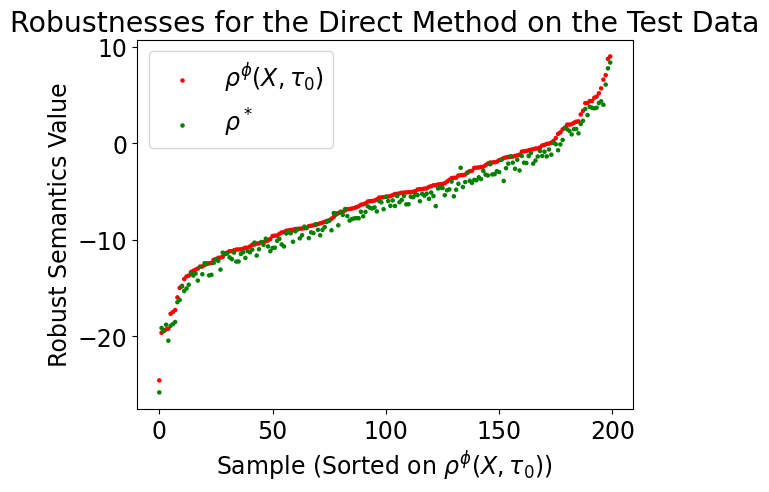

The Coverage of the Direct Method is:  0.93
Performing Experiment with the Indirect Method.


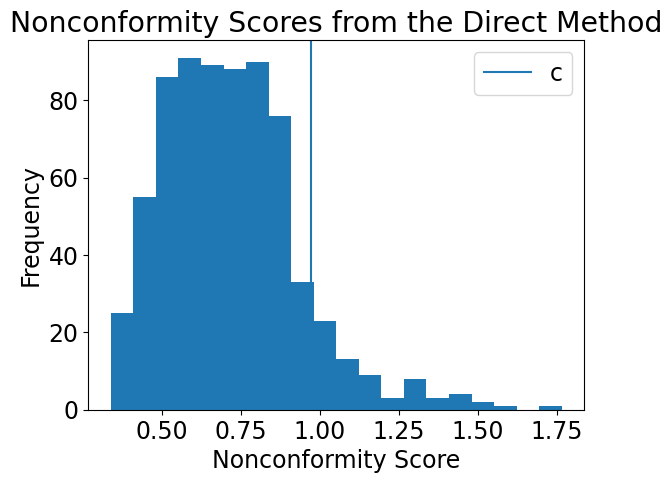

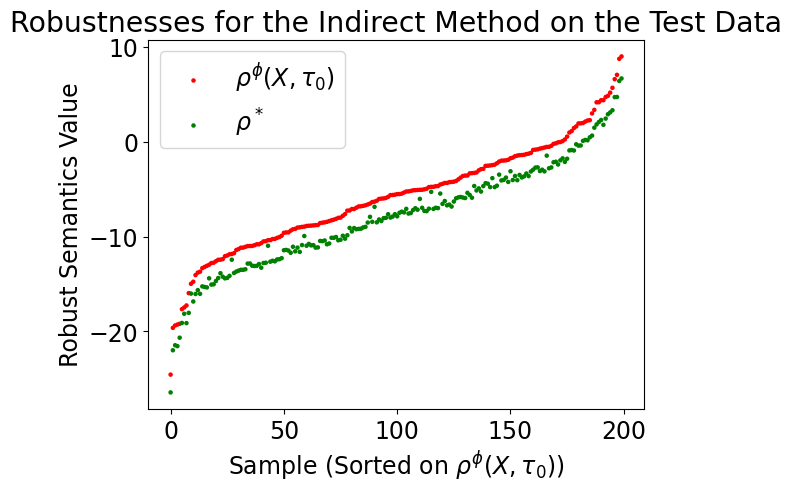

The Coverage of the Indirect Method is:  1.0
Conducting Experiment  2
Performing Experiment with the Direct Method.
The Coverage of the Direct Method is:  0.925
Performing Experiment with the Indirect Method.
The Coverage of the Indirect Method is:  1.0
Conducting Experiment  3
Performing Experiment with the Direct Method.
The Coverage of the Direct Method is:  0.935
Performing Experiment with the Indirect Method.
The Coverage of the Indirect Method is:  1.0
Conducting Experiment  4
Performing Experiment with the Direct Method.
The Coverage of the Direct Method is:  0.82
Performing Experiment with the Indirect Method.
The Coverage of the Indirect Method is:  1.0
Conducting Experiment  5
Performing Experiment with the Direct Method.
The Coverage of the Direct Method is:  0.885
Performing Experiment with the Indirect Method.
The Coverage of the Indirect Method is:  1.0
Conducting Experiment  6
Performing Experiment with the Direct Method.
The Coverage of the Direct Method is:  0.875
Perf

Performing Experiment with the Direct Method.
The Coverage of the Direct Method is:  0.91
Performing Experiment with the Indirect Method.
The Coverage of the Indirect Method is:  1.0
Conducting Experiment  42
Performing Experiment with the Direct Method.
The Coverage of the Direct Method is:  0.91
Performing Experiment with the Indirect Method.
The Coverage of the Indirect Method is:  1.0
Conducting Experiment  43
Performing Experiment with the Direct Method.
The Coverage of the Direct Method is:  0.885
Performing Experiment with the Indirect Method.
The Coverage of the Indirect Method is:  1.0
Conducting Experiment  44
Performing Experiment with the Direct Method.
The Coverage of the Direct Method is:  0.92
Performing Experiment with the Indirect Method.
The Coverage of the Indirect Method is:  1.0
Conducting Experiment  45
Performing Experiment with the Direct Method.
The Coverage of the Direct Method is:  0.915
Performing Experiment with the Indirect Method.
The Coverage of the Indi

In [7]:
experimental_size = 50
calibration_size = 700
test_size = 200
zeta_1 = 100
zeta_2 = 300
zeta_3 = 650
delta = 0.1


# Let's first write a function in computing the robust semantics given a trajectory.
def compute_robust_semantics(alt, vel):
    final_robustness = float("inf")
    for tau in range(len(alt)):
        time_robustness = min(alt[tau] - zeta_1, max(alt[tau] - zeta_2, zeta_3 - vel[tau]))
        final_robustness = min(final_robustness, time_robustness)
    return final_robustness

# We also need a function in computing the worst-case semantics given a trajectory and the prediction regions.
def compute_worst_robust_semantics(alt, vel, prediction_regions):
    collision_robustnesses = []
    height_robustnesses = []
    speed_robustnesses = []
    for tau in range(0, terminal_time + 1):
        if tau <= current_time:
            collision_robustness = alt[tau] - zeta_1
            height_robustness = alt[tau] - zeta_2
            speed_robustness = zeta_3 - vel[tau]
        else:
            # Since the predicate is affine, the minimum predicate robustness happens only when the dimension of interest changes to the maximal amount while the other dimensions remain the same.
            collision_robustness = (alt[tau] - prediction_regions[tau]) - zeta_1
            height_robustness = (alt[tau] - prediction_regions[tau]) - zeta_2
            speed_robustness = zeta_3 - (vel[tau] + prediction_regions[tau])
        collision_robustnesses.append(collision_robustness)
        height_robustnesses.append(height_robustness)
        speed_robustnesses.append(speed_robustness)
    # Compose the robustnesses together.
    final_robustness = float("inf")
    for tau in range(len(alt)):
        time_robustness = min(collision_robustnesses[tau], max(height_robustnesses[tau], speed_robustnesses[tau]))
        final_robustness = min(final_robustness, time_robustness)
    return final_robustness
    

# Conduct the experiment.
direct_coverages = []
indirect_coverages = []
for i in range(experimental_size):
    print("Conducting Experiment ", i + 1)
    # First, collect the calibration data.
    calib_alts = []
    calib_vels = []
    for _ in range(calibration_size):
        altitude, velocity = plane.generate_nominal_trajectory(tmax, simulation_step)
        calib_alts.append(altitude)
        calib_vels.append(velocity)
    # Next, we generate predictions on the calibration data.
    calib_alts_prefixes = [calib_alts[j][:current_time + 1] for j in range(len(calib_alts))]
    calib_vels_prefixes = [calib_vels[j][:current_time + 1] for j in range(len(calib_vels))]
    calib_pred_alts, calib_pred_vels = generate_predictions(calib_alts_prefixes, calib_vels_prefixes, alt_predictor, vel_predictor, normalization)
    # Then, we generate the test set for each experiment.
    test_alts = []
    test_vels = []
    for _ in range(test_size):
        altitude, velocity = plane.generate_nominal_trajectory(tmax, simulation_step)
        test_alts.append(altitude)
        test_vels.append(velocity)
    # We generate the predictions on the test data (This is done online in validation, but we generate here to avoid redundant executions).
    test_alts_prefixes = [test_alts[j][:current_time + 1] for j in range(len(test_alts))]
    test_vels_prefixes = [test_vels[j][:current_time + 1] for j in range(len(test_vels))]
    test_pred_alts, test_pred_vels = generate_predictions(test_alts_prefixes, test_vels_prefixes, alt_predictor, vel_predictor, normalization)
    
    # Let's first experiment with the direct method.
    print("Performing Experiment with the Direct Method.")
    # Now, let's perform conformal prediction.
    calib_robustnesses = [compute_robust_semantics(calib_alts[j], calib_vels[j]) for j in range(calibration_size)]
    calib_pred_robustnesses = [compute_robust_semantics(calib_pred_alts[j], calib_pred_vels[j]) for j in range(calibration_size)]
    direct_nonconformity_scores = [calib_pred_robustnesses[j] - calib_robustnesses[j] for j in range(calibration_size)]
    direct_nonconformity_scores.sort()
    direct_nonconformity_scores.append(float("inf"))
    p = int(np.ceil((calibration_size + 1) * (1 - delta)))
    c_direct = direct_nonconformity_scores[p - 1]
    # We plot the histogram of nonconformity scores for illustration if this is the first trial.
    if i == 0:
        plt.hist(direct_nonconformity_scores[:-1], bins = 20)
        plt.xlabel("Nonconformity Score")
        plt.ylabel("Frequency")
        plt.axvline(c_direct, label = "c")
        plt.legend()
        plt.title("Nonconformity Scores from the Direct Method")
        plt.savefig("plots/nonconformity_scores_direct.pdf")
        plt.show()
        # Let's save the experimental results.
        with open("results/direct_nonconformity_scores.json" , "w") as file:
            json.dump(direct_nonconformity_scores, file)
        with open("results/c_direct.json", "w") as file:
            json.dump(c_direct, file)
    # Now, we are ready to validate the results.
    direct_correct_count = 0
    direct_test_robustnesses = []
    direct_test_lowerbound_robustnesses = []
    for j in range(test_size):
        direct_test_robustness = compute_robust_semantics(test_alts[j], test_vels[j])
        direct_test_pred_robustness = compute_robust_semantics(test_pred_alts[j], test_pred_vels[j])
        direct_test_lowerbound_robustness = direct_test_pred_robustness - c_direct
        if direct_test_robustness >= direct_test_lowerbound_robustness:
            direct_correct_count += 1
        direct_test_robustnesses.append(direct_test_robustness)
        direct_test_lowerbound_robustnesses.append(direct_test_lowerbound_robustness)
    # We plot the scatter plot of the robustnesses for testing.
    if i == 0:
        sorted_direct_test_robustnesses, sorted_direct_test_lowerbound_robustnesses = zip(*sorted(zip(direct_test_robustnesses, direct_test_lowerbound_robustnesses)))
        dot_sizes = [5 for j in range(test_size)]
        plt.scatter([j for j in range(test_size)], sorted_direct_test_robustnesses, s=dot_sizes, color = "r", label= "$\\rho^\phi(X, \\tau_0)$")
        plt.scatter([j for j in range(test_size)], sorted_direct_test_lowerbound_robustnesses , s=dot_sizes, color = "g", label= "$\\rho^*$")
        plt.xlabel("Sample (Sorted on $\\rho^\phi(X, \\tau_0)$)")
        plt.ylabel("Robust Semantics Value")
        plt.legend()
        plt.title("Robustnesses for the Direct Method on the Test Data")
        plt.savefig("plots/direct_robustnesses_scatter.pdf")
        plt.show()
        # Save the experimental results.
        with open("results/direct_test_robustnesses.json", "w") as file:
            json.dump(direct_test_robustnesses, file)
        with open("results/direct_test_lowerbound_robustnesses.json", "w") as file:
            json.dump(direct_test_lowerbound_robustnesses, file)
    direct_coverage = direct_correct_count / test_size
    direct_coverages.append(direct_coverage)
    print("The Coverage of the Direct Method is: ", direct_coverage)
    
    # Let's now conduct an experiment with the indirect method with both union bound and normalization.
    print("Performing Experiment with the Indirect Method.")
    # Now, let's perform conformal prediction.
    indirect_nonconformity_scores = []
    for j in range(calibration_size):
        max_score = 0 - float("inf")
        for tau in range(current_time + 1, terminal_time + 1):
            ground_alt = calib_alts[j][tau]
            pred_alt = calib_pred_alts[j][tau]
            ground_vel = calib_vels[j][tau]
            pred_vel = calib_pred_vels[j][tau]
            error = ((ground_alt - pred_alt) ** 2 + (ground_vel - pred_vel) ** 2) ** (1 / 2)
            max_score = max(max_score, alphas[tau] * error)
        indirect_nonconformity_scores.append(max_score)
    indirect_nonconformity_scores.sort()
    indirect_nonconformity_scores.append(float("inf"))
    p = int(np.ceil((calibration_size + 1) * (1 - delta)))
    c_indirect = indirect_nonconformity_scores[p - 1]
    # Let's illustrate one example of nonconformity scores.
    if i == 0:
        plt.hist(indirect_nonconformity_scores[:-1], bins = 20)
        plt.xlabel("Nonconformity Score")
        plt.ylabel("Frequency")
        plt.axvline(c_indirect, label = "c")
        plt.legend()
        plt.title("Nonconformity Scores from the Direct Method")
        plt.savefig("plots/nonconformity_scores_indirect.pdf")
        plt.show()
        # Let's save the experimental results.
        with open("results/indirect_nonconformity_scores.json" , "w") as file:
            json.dump(indirect_nonconformity_scores, file)
        with open("results/c_indirect.json", "w") as file:
            json.dump(c_indirect, file)
    # Compute prediction regions.
    prediction_regions = dict()
    for tau in range(current_time + 1, terminal_time + 1):
        prediction_regions[tau] = c_indirect / alphas[tau]
    # Now, we are ready to validate the results.
    indirect_correct_count = 0
    indirect_test_robustnesses = []
    indirect_test_lowerbound_robustnesses = []
    for j in range(test_size):
        indirect_test_robustness = compute_robust_semantics(test_alts[j], test_vels[j])
        # We now call the previously written function for the worst-case semantics.
        indirect_test_lowerbound_robustness = compute_worst_robust_semantics(test_alts[j], test_vels[j], prediction_regions)
        if indirect_test_robustness >= indirect_test_lowerbound_robustness:
            indirect_correct_count += 1
        indirect_test_robustnesses.append(indirect_test_robustness)
        indirect_test_lowerbound_robustnesses.append(indirect_test_lowerbound_robustness)
    # We plot the scatter plot of the robustnesses for testing.
    if i == 0:
        sorted_indirect_test_robustnesses, sorted_indirect_test_lowerbound_robustnesses = zip(*sorted(zip(indirect_test_robustnesses, indirect_test_lowerbound_robustnesses)))
        dot_sizes = [5 for j in range(test_size)]
        plt.scatter([j for j in range(test_size)], sorted_indirect_test_robustnesses, s=dot_sizes, color = "r", label= "$\\rho^\phi(X, \\tau_0)$")
        plt.scatter([j for j in range(test_size)], sorted_indirect_test_lowerbound_robustnesses , s=dot_sizes, color = "g", label= "$\\rho^*$")
        plt.xlabel("Sample (Sorted on $\\rho^\phi(X, \\tau_0)$)")
        plt.ylabel("Robust Semantics Value")
        plt.legend()
        plt.title("Robustnesses for the Indirect Method on the Test Data")
        plt.savefig("plots/indirect_robustnesses_scatter.pdf")
        plt.show()
        # Save the experimental results.
        with open("results/indirect_test_robustnesses.json", "w") as file:
            json.dump(indirect_test_robustnesses, file)
        with open("results/indirect_test_lowerbound_robustnesses.json", "w") as file:
            json.dump(indirect_test_lowerbound_robustnesses, file)
    indirect_coverage = indirect_correct_count / test_size
    indirect_coverages.append(indirect_coverage)
    print("The Coverage of the Indirect Method is: ", indirect_coverage)

# Save the coverages.
with open("results/direct_coverages.json", "w") as file:
    json.dump(direct_coverages, file)
with open("results/indirect_coverages.json", "w") as file:
    json.dump(indirect_coverages, file)

Lastly, we plot the histograms on coverages.

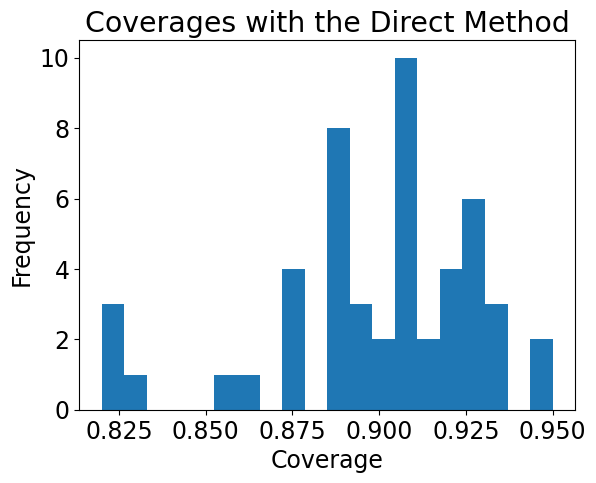

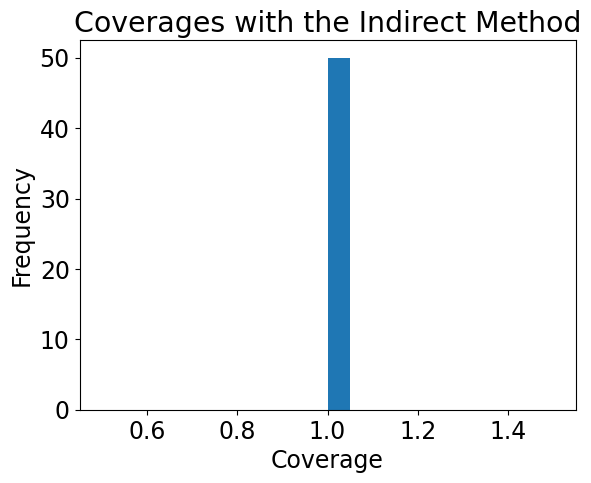

In [8]:
plt.hist(direct_coverages, bins = 20)
plt.title("Coverages with the Direct Method")
plt.xlabel("Coverage")
plt.ylabel("Frequency")
plt.savefig("plots/direct_coverages.pdf")
plt.show()

plt.hist(indirect_coverages, bins = 20)
plt.title("Coverages with the Indirect Method")
plt.xlabel("Coverage")
plt.ylabel("Frequency")
plt.savefig("plots/indirect_coverages.pdf")
plt.show()

# Citations

1. P. Heidlauf, A. Collins, M. Bolender, and S. Bak, “Verification challenges in f-16 ground collision
avoidance and other automated maneuvers.” in ARCH@ ADHS, 2018, pp. 208–217.

2. L. Lindemann, X. Qin, J. V. Deshmukh, and G. J. Pappas, “Conformal prediction for stl
runtime verification,” in Proc. of ICCPS, 2023, pp. 142–153.

3.  Y. Zhao, B. Hoxha, G. Fainekos, J. V. Deshmukh, and L. Lindemann, “Robust conformal prediction for stl runtime verification under distribution shift,” arXiv preprint arXiv:2311.09482,
2023.